In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

#Install these two packages
#------------------------------------------------
!pip install scispacy
#------------------------------------------------

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
import scispacy
import spacy
plt.style.use('fivethirtyeight')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [6]:
data = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
data.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,arxiv_id,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998.0,unk,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704.0,unk,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,True,True,custom_license,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125.0,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...


In [8]:
data.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'arxiv_id',
       'has_pdf_parse', 'has_pmc_xml_parse', 'full_text_file', 'url'],
      dtype='object')

In [9]:
data.isnull().any()

cord_uid                       False
sha                             True
source_x                       False
title                           True
doi                             True
pmcid                           True
pubmed_id                       True
license                        False
abstract                        True
publish_time                    True
authors                         True
journal                         True
Microsoft Academic Paper ID     True
WHO #Covidence                  True
arxiv_id                        True
has_pdf_parse                  False
has_pmc_xml_parse              False
full_text_file                  True
url                             True
dtype: bool

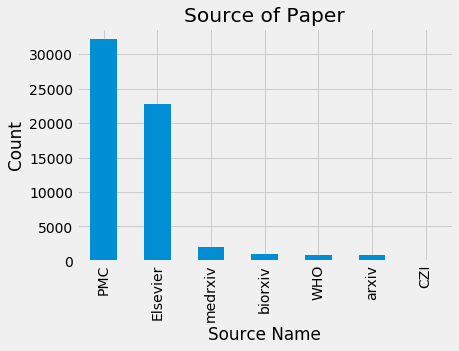

In [10]:
data['source_x'].value_counts().plot.bar()
plt.title("Source of Paper")
plt.ylabel("Count")
plt.xlabel("Source Name")
plt.show()
#PMC:PubMed Central is a free digital repository that archives publicly accessible full-text 
#scholarly articles that have been published within the biomedical and life sciences journal literature.

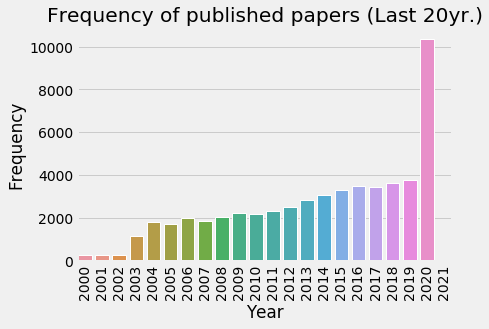

In [11]:
#Last 20 years frequencies
plt.title("Frequency of published papers (Last 20yr.)")
publish_time = data['publish_time'].dropna()
publish_time = publish_time.apply(lambda x: int(x[:4])) #get the year
publish_time_last20yr = publish_time[publish_time >= 2000]
sns.set(style="whitegrid")
ax = sns.countplot(publish_time_last20yr)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

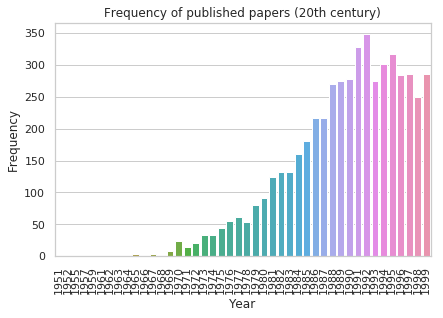

In [12]:
#20th century
plt.title("Frequency of published papers (20th century)")
publish_time_20th = publish_time[publish_time < 2000]
sns.set(style="whitegrid")
ax = sns.countplot(publish_time_20th)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [13]:
#Download SciSpacy en_core_sci_lg Model
#A full spaCy pipeline for biomedical data with a ~785k vocabulary and 600k word vectors.
!wget --header="Host: s3-us-west-2.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://github.com/allenai/scispacy" "https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz" -O "en_core_sci_lg-0.2.4.tar.gz" -c

#Extract the .tar.gz file
import tarfile
fname="/kaggle/working/en_core_sci_lg-0.2.4.tar.gz"
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()
elif fname.endswith("tar"):
    tar = tarfile.open(fname, "r:")
    tar.extractall()
    tar.close()

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2020-05-09 00:03:42--  https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.196.80
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.196.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 500565835 (477M) [application/x-tar]
Saving to: ‘en_core_sci_lg-0.2.4.tar.gz’

en_core_sci_lg-0.2. 100%[===================>] 477.38M  92.2MB/s    in 5.1s    

2020-05-09 00:03:47 (92.9 MB/s) - ‘en_core_sci_lg-0.2.4.tar.gz’ saved [500565835/500565835]



In [14]:
#Broken due to allennlp

# #NER
from spacy import displacy
nlp = spacy.load("en_core_web_lg") #Spacy

In [15]:
print("Text : ", data["abstract"][2])
doc = nlp(data["abstract"][2])
displacy.render(doc, style='ent')

Text :  Hepatitis C virus (HCV) is an important human pathogen that affects ∼100 million people worldwide. Its RNA genome codes for a polyprotein, which is cleaved by viral and cellular proteases to produce at least 10 mature viral protein products. We report here the discovery of a novel HCV protein synthesized by ribosomal frameshift. This protein, which we named the F protein, is synthesized from the initiation codon of the polyprotein sequence followed by ribosomal frameshift into the −2/+1 reading frame. This ribosomal frameshift requires only codons 8–14 of the core protein‐coding sequence, and the shift junction is located at or near codon 11. An F protein analog synthesized in vitro reacted with the sera of HCV patients but not with the sera of hepatitis B patients, indicating the expression of the F protein during natural HCV infection. This unexpected finding may open new avenues for the development of anti‐HCV drugs.


In [16]:
nlp = spacy.load("/kaggle/working/en_core_sci_lg-0.2.4/en_core_sci_lg/en_core_sci_lg-0.2.4/") #SciSpacy
doc = nlp(data["abstract"][2])
displacy.render(doc, style='ent')

In [17]:
titles = data['title'].dropna().values
abstracts = data['abstract'].dropna().values

In [18]:
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(vocab=nlp.vocab)
tokenized = tokenizer(' '.join(abstracts))
print("Number of tokenized words: ", len(tokenized))

Number of tokenized words:  9504827


In [19]:
from collections import Counter
from tqdm import tqdm_notebook
vocab = Counter()
for token in tqdm_notebook(tokenized):
    vocab[token.text] += 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [20]:
print("Number of unique tokens:", len(vocab))
from nltk.corpus import stopwords
stopword = stopwords.words('english')
vocab_pure = Counter()
for k, v in vocab.items():
    if k.lower() not in stopword:
        vocab_pure[k] = v
print("Number of unique tokens (after stopword removal)", len(vocab_pure))

Number of unique tokens: 381422
Number of unique tokens (after stopword removal) 381103


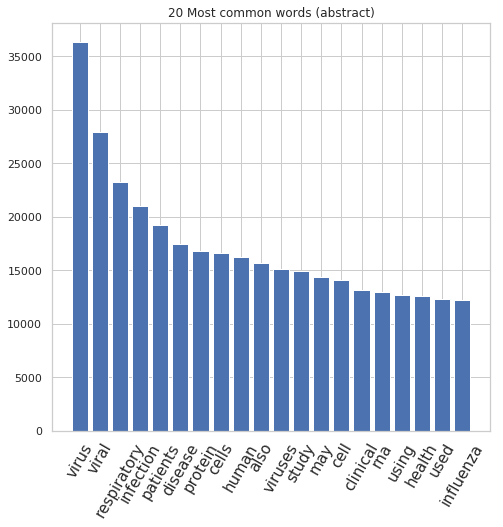

In [21]:
k = 20
x = [name[0].lower() for name in vocab_pure.most_common(k)]
y = [value[1] for value in vocab_pure.most_common(k)]
plt.figure(figsize=(7, 7))
plt.bar(x, y)
plt.title(f"{k} Most common words (abstract)")
plt.xticks(rotation=60, fontsize=15)
plt.show()

In [22]:
tokenized = tokenizer(' '.join(titles))
print("Number of tokenized words: ", len(tokenized))
vocab = Counter()
for token in tqdm_notebook(tokenized):
    vocab[token.text] += 1
print("Number of unique tokens:", len(vocab))
vocab_pure = Counter()
for k, v in vocab.items():
    if k.lower() not in stopword:
        vocab_pure[k] = v
print("Number of unique tokens (after stopword removal)", len(vocab_pure))

Number of tokenized words:  741552


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Number of unique tokens: 74005
Number of unique tokens (after stopword removal) 73700


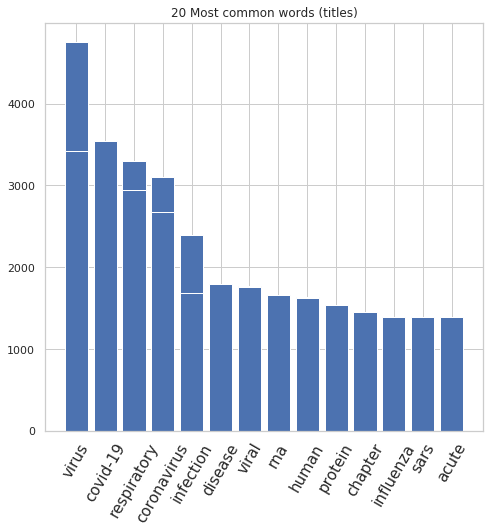

In [23]:
k = 20
x = [name[0].lower() for name in vocab_pure.most_common(k)]
y = [value[1] for value in vocab_pure.most_common(k)]
plt.figure(figsize=(7, 7))
plt.bar(x, y)
plt.title(f"{k} Most common words (titles)")
plt.xticks(rotation=60, fontsize=15)
plt.show()

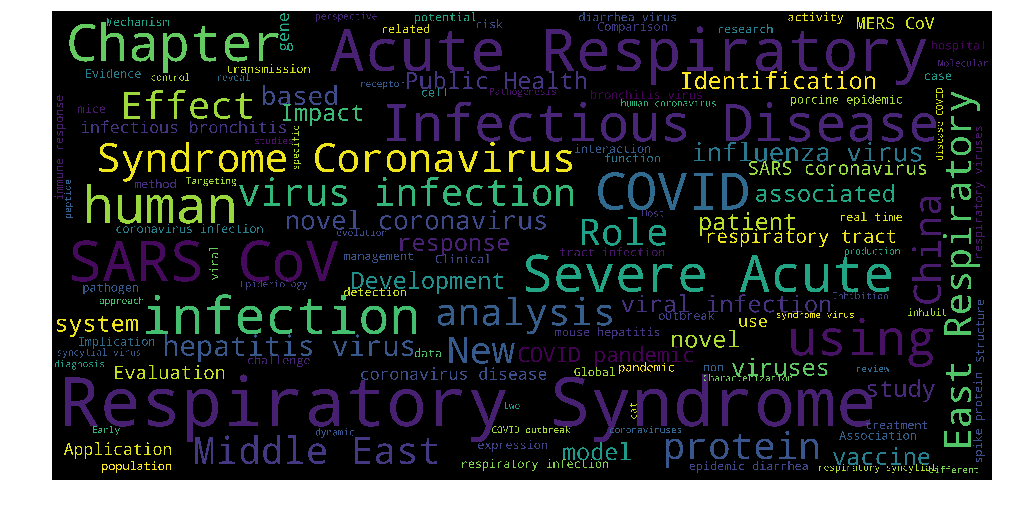

In [24]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
plt.figure(figsize=(15, 15))
wordcloud = WordCloud(
            background_color='black',
            stopwords=stopwords,
            max_words=200,
            random_state=42, scale=100
            ).generate(' '.join(titles))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [25]:
!pip install allennlp
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/bidaf-model-2017.09.15-charpad.tar.gz")

     |████████████████████████████████| 30.8 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.2 MB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 40.6 MB/s eta 0:00:01


     |████████████████████████████████| 3.2 MB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 1.3 MB/s  eta 0:00:01
ERROR: scispacy 0.2.4 has requirement spacy>=2.2.1, but you'll have spacy 2.1.9 which is incompatible.
ERROR: en-core-web-sm 2.2.5 has requirement spacy>=2.2.2, but you'll have spacy 2.1.9 which is incompatible.
ERROR: en-core-web-lg 2.2.5 has requirement spacy>=2.2.2, but you'll have spacy 2.1.9 which is incompatible.
ERROR: awscli 1.18.56 has requirement botocore==1.16.6, but you'll have botocore 1.15.49 which is incompatible.
  Attempting uninstall: blis
    Found existing installation: blis 0.4.1
    Uninstalling blis-0.4.1:
      Successfully uninstalled blis-0.4.1
  Attempting uninstall: preshed
    Found existing installation: preshed 3.0.2
    Uninstalling preshed-3.0.2:
      Successfully uninstalled preshed-3.0.2
  Attempting uninstall: thinc
    Found existing installation: thinc 7.3.1
    Uninstalling thinc-7.3.1:
      Successfully uninst

100%|██████████| 46175392/46175392 [00:01<00:00, 38855949.06B/s]
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/opt/conda/lib/python3.6/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:56: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  UserWarning)


In [51]:
passage = ''
for abstract in data['abstract'].dropna().values:
    passage += ' '+ abstract

In [56]:
limit = int(1e4)
result = predictor.predict(passage=passage[:limit], question='What is Coronavirus?')
result['best_span_str']

'a member of the carcinoembryonic antigen (CEA) family. Isoforms of murine CEACAM1 serve as receptors for mouse hepatitis virus (MHV), a murine coronavirus. Here we report the crystal structure of soluble murine sCEACAM1a[1,4], which is composed of two Ig-like domains and has MHV neutralizing activity. Its N-terminal domain has a uniquely folded CC′ loop that encompasses key virus-binding residues. This is the first atomic structure of any member of the CEA family, and provides a prototypic architecture for functional exploration of CEA family members. We discuss the structural basis of virus receptor activities of murine CEACAM1 proteins, binding of Neisseria to human CEACAM1, and other homophilic and heterophilic interactions of CEA family members. Hepatitis C virus (HCV) is an important human pathogen that affects ∼100 million people worldwide. Its RNA genome codes for a polyprotein, which is cleaved by viral and cellular proteases to produce at least 10 mature viral protein product

In [28]:
#Source: https://www.kaggle.com/shahules/eda-find-similar-papers-easily/log
import tensorflow_hub as hub
import tensorflow as tf
import gensim

def prepare_similarity(vectors):
    similarity=cosine_similarity(vectors)
    return similarity

def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]



data = data[['abstract', 'title']].dropna()
module_url = "../input/universalsentenceencoderlarge4" 
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.load(module_url)

limit = 7000
titles = data['title'].dropna()
embed_vectors = embed(titles[:limit].values)['outputs'].numpy()
sentence_list = titles.values.tolist()


In [43]:
from sklearn.metrics.pairwise import cosine_similarity
sentence = titles.iloc[10]
print("Find similar research papers for :")
print(sentence)

similarity_matrix=prepare_similarity(embed_vectors)
similar=get_top_similar(sentence,sentence_list,similarity_matrix, 10)

Find similar research papers for :
Association of HLA class I with severe acute respiratory syndrome coronavirus infection


In [44]:
for sentence in similar:
    print(sentence)

Association of HLA class I with severe acute respiratory syndrome coronavirus infection
Association of human leukocyte antigen class II alleles with severe Middle East respiratory syndrome-coronavirus infection
Antibody-dependent infection of human macrophages by severe acute respiratory syndrome coronavirus
Strongyloides Hyperinfection Syndrome Combined with Cytomegalovirus Infection
Coronavirus infections in hospitalized pediatric patients with acute respiratory tract disease
Association of Interleukin-8 and Neutrophils with Nasal Symptom Severity During Acute Respiratory Infection
Association of TNF-α –308G/A, SP-B 1580 C/T, IL-13 –1055 C/T gene polymorphisms and latent adenoviral infection with chronic obstructive pulmonary disease in an Egyptian population
Severe Acute Respiratory Syndrome Coronavirus Envelope Protein Ion Channel Activity Promotes Virus Fitness and Pathogenesis
Severe Acute Respiratory Syndrome–associated Coronavirus Infection
Clinical and epidemiological predicto